## Step 1
Imports and initialisation of a LJ calculator

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ase, ase.io
from ase.visualize import view
from ase.optimize import BFGS
from ase.calculators.lj import LennardJones
from pele.storage import Database

lj_calc = LennardJones(sigma=1.0, epsilon=1.0, rc=12.0)

## Step 2
Initialisation of the simulation box. Parameters:
- 19 LJ atoms, I've chosen He
- Simulation box, side length is 12 - will adjust and justify with research
- Initialisation of positions, random within the box - will adjust and justify with research

### Simulation Box Length
Chosen 12 as suggested in assignment details

### Initial positions
When randomised across the entire box space, particles are so spaced out that instead of forming one 19-atom cluster, they form mini-clusters (typically 2 - 6 atoms, e.g. see trig-bipyramidal and tetrahedral structures attached). 

The reason for this is that the atoms are so far apart that they are not included in the calculation due to the cut-off (set at 4 Å). Even if the cut-off is increased to the size of the simulation box, the force between particles is so low that they will rarely converge.

So instead of randomising the particles across the entire simulation box, restrict the random space to a theoretical box in the centre of the simulation box that is half the size of entire simulation box.

In [2]:
n = 19 # number of LJ atoms
box_length = 12 # length of box side

def initialise_structure(n, box_length):
    
    cell = np.eye(3)*box_length # 3x3 matrix with 
    atoms = ase.Atoms(pbc=True, cell = cell)
    for i in range(n):
        #pos = np.random.rand(3)*cell[1,1] ## randomising positions across the entire simulation box -- doesn't yield desired structure as discussed in the above markdown cell
        pos = np.random.uniform(box_length*0.25, box_length*0.75, size = 3) # generates cartesian coordinates in the center of the simulation box 
        atoms.append(ase.Atom('He', position = pos))

    return atoms

lj_19 = initialise_structure(19, 12)

In [3]:
view(lj_19, viewer='x3d')

## Step 3

Test minimisation to determine parameters `fmax` and `steps` for an appropriate level of convergence.

Through various trials, the energy value (given to 6 decimal places here) doesn't fluctuate much (or at all) below `fmax = 0.001`, thus this seems a reasonable cutoff for a minima such that computation isn't "wasted"

However, I will come back to this, because instpecting fmax across the steps reveals that after 1024 the given trajectory isn't necessarily the lowest energy explored. There should be a way extract the position of the atoms at the lowest energy explored across the 1024 steps if it doesn't converge below `fmax = 0.001`

In [4]:
def minimise_structure(atoms, f_max=0.001, steps = 1024, id = "test"):
    atoms.calc = lj_calc
    dyn = BFGS(atoms=atoms, trajectory=f'./trajectories/{atoms.symbols}_{id}.traj') # set up BFGS minimiser for the desired Atoms object
    dyn.run(fmax=f_max,steps=steps) # perform minimisation

minimise_structure(lj_19)

      Step     Time          Energy          fmax
BFGS:    0 13:15:40       45.669016      584.880303
BFGS:    1 13:15:40        7.104729      266.919801
BFGS:    2 13:15:40       -8.886765        8.676235
BFGS:    3 13:15:40       -9.388610        3.316426
BFGS:    4 13:15:40      -10.301504        3.539912
BFGS:    5 13:15:40       15.392868      492.751394
BFGS:    6 13:15:40      -11.887965        7.072554
BFGS:    7 13:15:40      -13.269107        3.868881
BFGS:    8 13:15:40        6.140577      158.522317
BFGS:    9 13:15:40      -14.071922        4.083295
BFGS:   10 13:15:40      -14.756769        4.668153
BFGS:   11 13:15:40      -11.440116       92.072616
BFGS:   12 13:15:40      -15.846969        9.398876
BFGS:   13 13:15:40      -15.971374        4.028950
BFGS:   14 13:15:40      -15.347195       19.185767
BFGS:   15 13:15:40      -16.442958        4.325212
BFGS:   16 13:15:40      -16.693779        3.784769
BFGS:   17 13:15:40      -16.982622        3.743340
BFGS:   18 13:

In [5]:
view(lj_19, viewer='x3d')

## Step 4

Performing 100 minimisation cycles starting from a randomised inital structure each time. Generates a database of minim

In [6]:
n = 19 # number of LJ atoms
box_length = 12 # length of box side

energies = []
structures = []

for i in range(100):
    lj_19 = initialise_structure(n = n, box_length = box_length)
    minimise_structure(lj_19, id = i)

    energy = lj_19.get_potential_energy()
    energies.append(energy)
    structures.append(lj_19)

      Step     Time          Energy          fmax
BFGS:    0 13:15:41  1566021.861294 55010463.761322
BFGS:    1 13:15:41      120.804155     2133.294458
BFGS:    2 13:15:41      113.005551     2133.209606
BFGS:    3 13:15:41      112.196492     2128.097059
BFGS:    4 13:15:41      108.892915     2009.565000
BFGS:    5 13:15:41      115.223883     1766.770966
BFGS:    6 13:15:41      102.664654     1431.677501
BFGS:    7 13:15:41      153.888606     1403.155604
BFGS:    8 13:15:41      128.962673      994.201421
BFGS:    9 13:15:41       59.954372      511.548224
BFGS:   10 13:15:41       17.017034      310.177026
BFGS:   11 13:15:41        2.665632      188.238566
BFGS:   12 13:15:41       -3.176693      106.266307
BFGS:   13 13:15:41       -6.309070       56.809252
BFGS:   14 13:15:41       -8.375472       28.426243
BFGS:   15 13:15:41       -9.724046       11.030399
BFGS:   16 13:15:41      -10.554729        4.101735
BFGS:   17 13:15:41      -10.919409        3.393429
BFGS:   18 13:

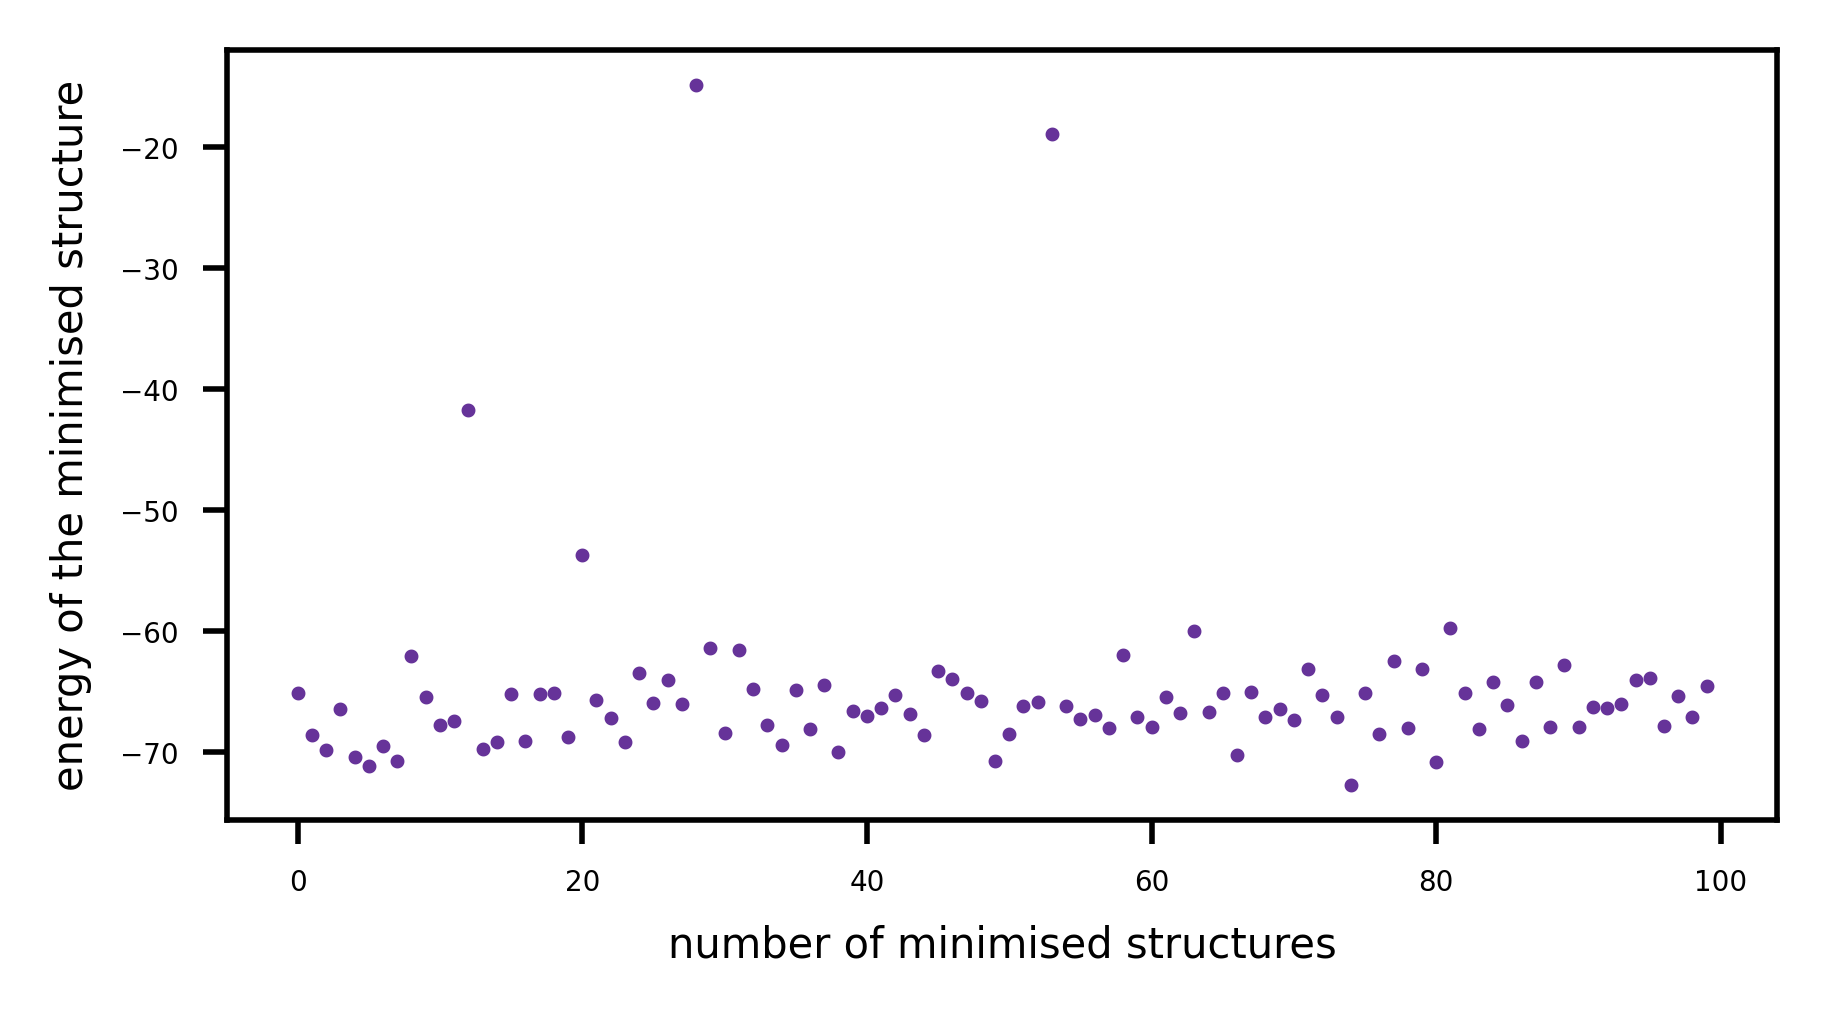

In [7]:
fig=plt.figure(num=None,figsize=(4,2),dpi=500,facecolor='w',edgecolor='k')
plt.tick_params(axis='both', which='major', labelsize=4)
plt.xlabel('number of minimised structures',fontsize=6)
plt.ylabel('energy of the minimised structure',fontsize=6)
plt.scatter(np.arange(len(energies)),energies,color='rebeccapurple',s=1)
plt.savefig('LJ19_min.png')

## Step 5

Implementation of the basin hopping algorithm

In [8]:
def perturb_structure(atoms, method = 'wild', magnitude = 3.0):
    '''
    Pertubation Methods

    'wild' - randomly selects one atom and changes all of its coordinates randomly within a restricted
    box space (if it was moved randomly across the entire box space, it may move outside the cutoff of
    all atoms in the structure and effectively reduces the LJ19 cluster to an LJ18 cluster.), i.e. moves
    a random atom in a random directions by a random amount.

    'stretch' - calculates the centroid of the cluster, then moves all the atoms away from that centroid
    before performing the energy minimisation. Additional parameter can control how far away all of the
    atoms are moved.

    'sweep' - computes cluster centroid, moves the k-furthest atoms in a random directions by a random amount.
    Based on the idea that the core of the cluster is likely stable, but the outermost atoms are those that
    need to be displaced.

    'swap' - swap two random atoms coordinates. e.g. randomly swap the x coordinate of atom a with the x
    coordinate of atom b. OR randomly swap the y coordinate of atom a with the z coordinate of atom b
    '''

    if method == 'wild':
        atom_index = np.random.randint(len(atoms) - 1)
        box_length = atoms.cell[0][0]
        atoms.positions[atom_index] = np.random.uniform(box_length*0.25, box_length*0.75, size = 3)

    elif method == 'stretch':
        centroid = np.mean(atoms.positions, axis = 0)
        vectors = atoms.positions - centroid
        norms = np.linalg.norm(vectors, axis = 1)
        mask = norms > 0.0
        unit_vectors = vectors[mask]/norms[mask, None]

        lengths = np.random.uniform(low = 0.0, high = magnitude, size = (unit_vectors.shape[0], 1))
        atoms.positions += unit_vectors * lengths


    elif method == 'sweep':
        k = 3

        # Computing distance from centre of the cluster
        centroid = np.mean(atoms.positions, axis = 0)
        vectors = atoms.positions - centroid
        distances = np.linalg.norm(vectors, axis = 1)
        
        #identifying the k-furthest atoms from the centre of the cluster
        idx = np.argsort(distances)[-k:][::-1]

        rng = np.random.default_rng()
        directions = rng.normal(size = (len(idx), 3)) #randomising the directions each of the k-furthest atoms will be moved
        directions /= np.linalg.norm(directions, axis=1, keepdims = True) #normalising to produce the unit vector
        lengths = np.random.uniform(low = 0.0, high = magnitude, size = (directions.shape[0], 1)) #random magnitudes
        
        atoms.positions[idx] += directions * lengths
    
    elif method == 'swap':
        print(atoms.positions)
        rng = np.random.default_rng()
        
        #randomising the atoms selected to be swapped
        atom_a = rng.integers(0, n)
        atom_b = rng.integers(0, n)

        #randomising the x, y, z coordinate to be swapped
        comp_a = rng.integers(0, 3)
        comp_b = rng.integers(0, 3)

        atoms.positions[atom_a, comp_a], atoms.positions[atom_b, comp_b] = atoms.positions[atom_b, comp_b], atoms.positions[atom_a, comp_a]

    return atoms


In [9]:
n = 19 # number of LJ atoms
box_length = 12 # length of box side

energies = []
structures = []

for i in range(5):
    if i == 0:
        lj_19 = initialise_structure(n = n, box_length = box_length)
    else:
        lj_19 = perturb_structure(minimum, method = 'stretch')

    minimise_structure(lj_19, id = i)

    energy = lj_19.get_potential_energy()
    energies.append(energy)
    structures.append(lj_19)

    # minimum variable stores the structure with the lowest energy
    if energy == min(energies):
        minimum = lj_19.copy() 

      Step     Time          Energy          fmax
BFGS:    0 13:17:08    22704.999122   520170.431981
BFGS:    1 13:17:08     1135.753770    18018.337362
BFGS:    2 13:17:08       48.970392      813.416368
BFGS:    3 13:17:08        3.286387      188.222811
BFGS:    4 13:17:08        2.349640      187.074199
BFGS:    5 13:17:08       10.705577      240.499584
BFGS:    6 13:17:08        1.872837      193.083350
BFGS:    7 13:17:08       -0.000790      151.507218
BFGS:    8 13:17:08       -6.507668       42.478297
BFGS:    9 13:17:08       -7.961647       38.813356
BFGS:   10 13:17:08       -8.463483       31.356947
BFGS:   11 13:17:08       -4.857413       85.638626
BFGS:   12 13:17:08      -10.413861        5.825454
BFGS:   13 13:17:08      -11.016795        4.088115
BFGS:   14 13:17:08      -12.377386        3.211923
BFGS:   15 13:17:08       -3.428829      161.085832
BFGS:   16 13:17:08      -12.919118        2.838272
BFGS:   17 13:17:08      -13.377649        4.585931
BFGS:   18 13:

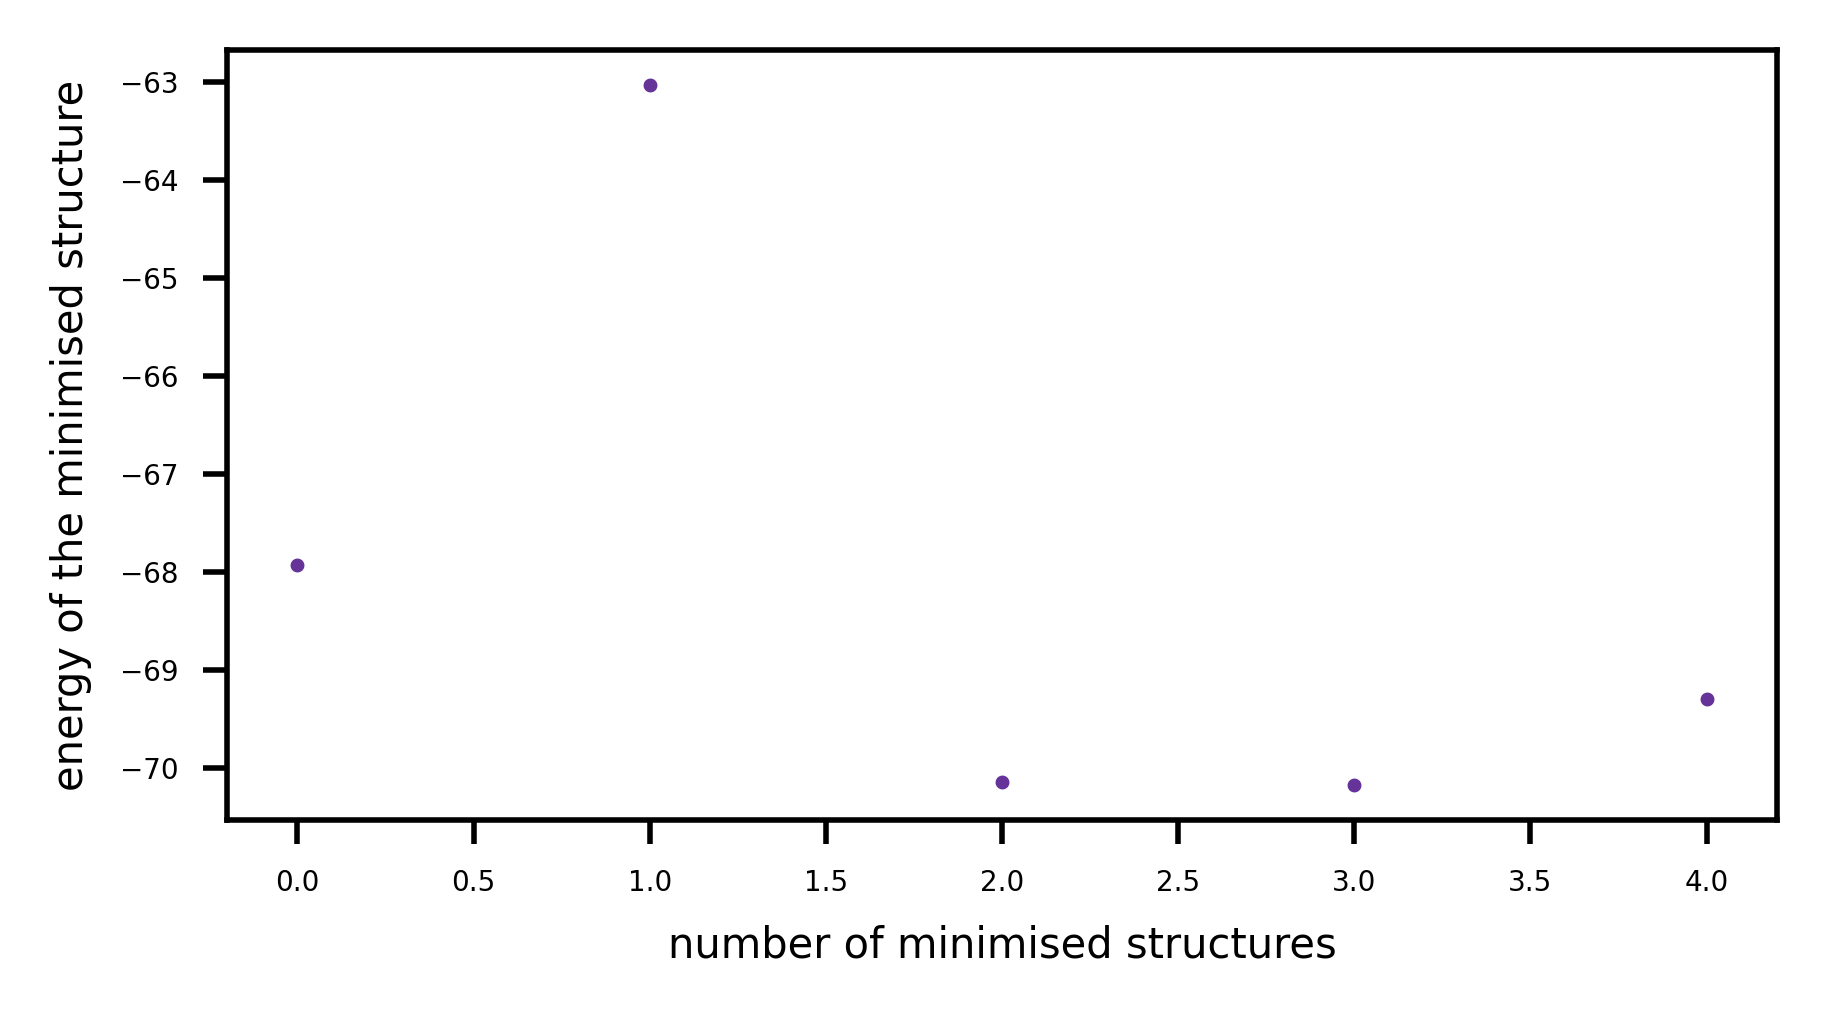

In [10]:
fig=plt.figure(num=None,figsize=(4,2),dpi=500,facecolor='w',edgecolor='k')
plt.tick_params(axis='both', which='major', labelsize=4)
plt.xlabel('number of minimised structures',fontsize=6)
plt.ylabel('energy of the minimised structure',fontsize=6)
plt.scatter(np.arange(len(energies)),energies,color='rebeccapurple',s=1)
plt.savefig('./images/LJ19_min.png')

In [11]:
from pele.systems import BaseSystem
from pele.mindist import MinPermDistAtomicCluster
from pele.landscape import ConnectManager
from pele.potentials import LJ
from pele.transition_states import orthogopt

class LennardJonesCluster(BaseSystem):
    def __init__(self, natoms):
        super(LennardJonesCluster, self).__init__()
        self.natoms = natoms
        self.params.database.accuracy = 0.001

    def get_potential(self):
        return LJ(self.natoms)
    
    def get_mindist(self):
        permlist = [range(self.natoms)]
        return MinPermDistAtomicCluster(permlist = permlist, niter=10)
    
    def get_orthogonalize_to_zero_eigenvectors(self):
        return orthogopt

In [23]:
n = 19
system = LennardJonesCluster(n)
db = system.create_database()

for structure, energy in zip(structures, energies):
    positions = np.asarray(structure.positions, dtype=float).ravel()
    db.addMinimum(energy, positions)

manager = ConnectManager(db, strategy="gmin")

for i in range(db.number_of_minima() - 1):
    min1, min2 = manager.get_connect_job()
    
    connect = system.get_double_ended_connect(min1, min2, db)
    connect.connect()
db.number_of_minima()

will compute the lowest eigenvector by diagonalizing the Hessian
populating list of minima not connected to the global minimum
sending a connect job to connect all minima with the global minimum 4 3
************************************************************
starting a double ended connect run between
        minimum 1: id 4 energy -70.171055
        minimum 2: id 3 energy -70.145149
        dist 2.116041
************************************************************

======== starting connect cycle 0 ========
finding a good pair to try to connect
Gdist has 2 nodes and 3 edges
best guess for path.  (dist=0.0 means the path is known)
    path guess 4 3 2.1160407058959523

starting NEB run to try to connect minima 4 3 1.9947511599314391
    NEB: nimages   19
    NEB: nsteps    190
    NEB: verbosity 0
NEB finished after 190 steps, rms 8.767290e-01
from NEB search found 3 transition state candidates

refining transition state from NEB climbing image: 1 out of 3
will compute the lowest eige

41

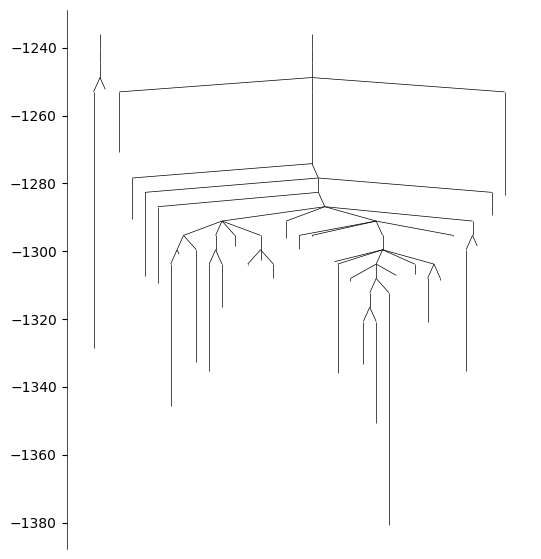

In [24]:
from pele.utils.disconnectivity_graph import database2graph, DisconnectivityGraph
graph = database2graph(db)
dg = DisconnectivityGraph(graph)
dg.calculate()
dg.plot()
plt.show()

In [15]:
for m in db.minima():
    print(m.energy)
    break

-1380.535866633447


In [25]:
m.energy/19

-72.65978245439196

In [18]:
len(db.minima())

32

### Analysis of Pertubation Methods
#### 'Wild'

#### 'Stretch'

#### 'Sweep'

#### 'Swap'